# Assignment 1
## Setup

In [56]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Question 1

In [57]:
# load local model file and initialize model class
from DynLaborFertModel import DynLaborFertModelClass
model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3}) # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim

In [58]:
model.solve()

In [59]:
model.simulate()

In [60]:
modelbank = {}
for i_b in range(50,55):
    modelbank[i_b] = {}
    b1 = i_b / 1000
    modelbank[i_b]['baseline'] = model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': b1})
    model.solve()
    model.simulate()

In [69]:
for i_b in range(50,55):
    response = np.mean(modelbank[i_b]['baseline'].sim.h[modelbank[i_b]['baseline'].sim.time_since_birth==0])/np.mean(modelbank[i_b]['baseline'].sim.h[modelbank[i_b]['baseline'].sim.time_since_birth==-1]) -1
    print(f'beta_1 = {modelbank[i_b]["baseline"].par.beta_1:.3f}', f'avg_response = {response:.2%}')

beta_1 = 0.050 avg_response = -9.58%
beta_1 = 0.051 avg_response = -9.73%
beta_1 = 0.052 avg_response = -9.88%
beta_1 = 0.053 avg_response = -10.02%
beta_1 = 0.054 avg_response = -10.17%


## Question 2

In [71]:
i_b = 53
modelbank[i_b]['tax_increase'] = model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3, 'beta_1': b1, 'tau': 0.1*1.01})
model.solve()
model.simulate()
    

KeyError: 'base'

In [139]:
#Allocate
marshall_total = np.zeros(par.T)
marshall_child = np.zeros(par.T)
marshall_nochild = np.zeros(par.T)


for t in range(model.par.T):
    #Conditions (Index of child arrival is identical in baseline and tax_increase model)
    with_child = modelbank[i_b]['tax_increase'].sim.n[:,t]>0
    without_child = modelbank[i_b]['tax_increase'].sim.n[:,t]==0
    
    marshall_total[t]   = (np.mean(modelbank[i_b]['tax_increase'].sim.h[:,t]) - np.mean(modelbank[i_b]['baseline'].sim.h[:,t])) / np.mean(modelbank[i_b]['baseline'].sim.h[:,t])
    marshall_child[t]   = (np.mean(modelbank[i_b]['tax_increase'].sim.h[with_child,t]) - np.mean(modelbank[i_b]['baseline'].sim.h[with_child,t])) / np.mean(modelbank[i_b]['baseline'].sim.h[with_child,t])
    marshall_nochild[t] = (np.mean(modelbank[i_b]['tax_increase'].sim.h[without_child,t]) - np.mean(modelbank[i_b]['baseline'].sim.h[without_child,t])) / np.mean(modelbank[i_b]['baseline'].sim.h[without_child,t])
    
print('Marhallian response to tax increase', marshall_child)

Marhallian response to tax increase [        nan -0.00114389 -0.00117713 -0.00120083 -0.00125297 -0.00119495
 -0.00120936 -0.00095983 -0.00172181 -0.00083048]


/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_78590/3350737640.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


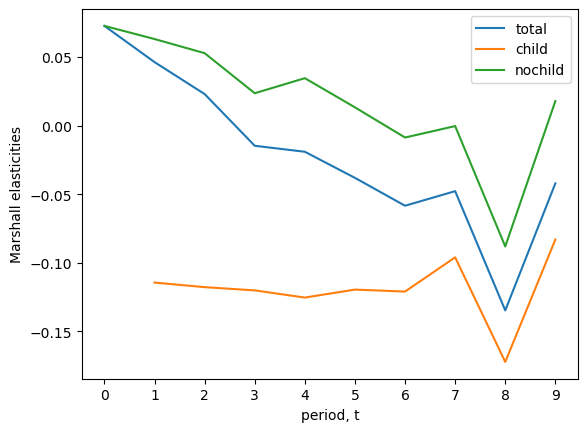

In [140]:
fig, ax = plt.subplots()
ax.plot(range(par.simT),marshall_total*100,label='total')
ax.plot(range(par.simT),marshall_child*100,label='child')
ax.plot(range(par.simT),marshall_nochild*100,label='nochild')
ax.set(xlabel='period, t',ylabel=f'Marshall elasticities',xticks=range(par.simT))
ax.legend()
fig.show()

## Tests

In [136]:
modelbank[i_b]['tax_increase'].sim.n - modelbank[i_b]['baseline'].sim.n

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

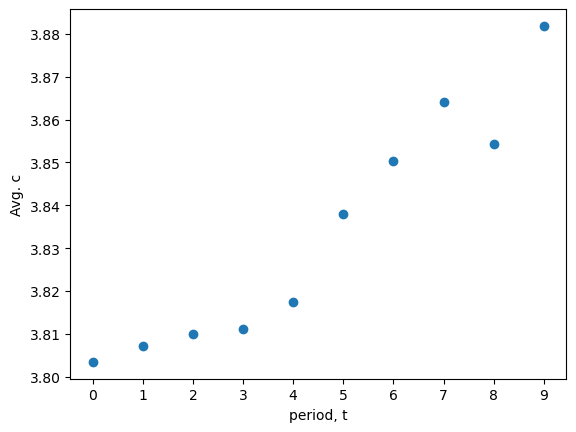

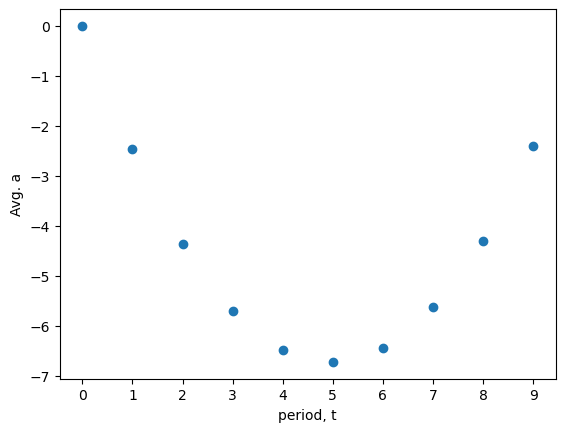

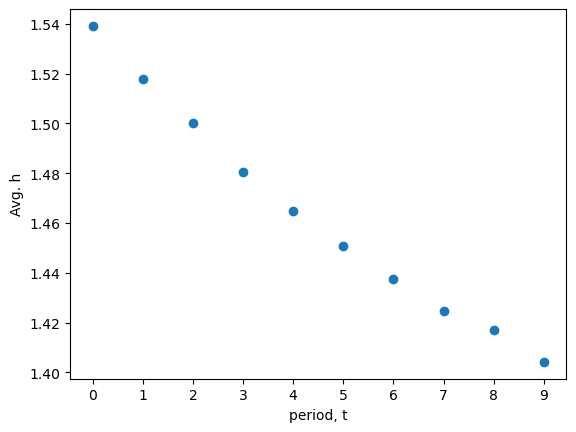

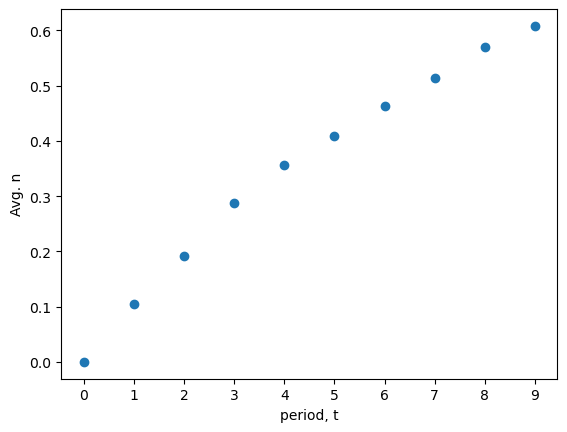

In [30]:
# plot behavior
for var in ('c','a','h','n'):
    fig, ax = plt.subplots()
    ax.scatter(range(par.simT),np.mean(getattr(sim,var),axis=0),label='Simulated')
    ax.set(xlabel='period, t',ylabel=f'Avg. {var}',xticks=range(par.simT))

In [34]:
# birth
birth = np.zeros(sim.n.shape,dtype=np.int_)
birth[:,1:] = (sim.n[:,1:] - sim.n[:,:-1]) > 0

# time since birth
periods = np.tile([t for t in range(par.simT)],(par.simN,1))
time_of_birth = np.max(periods * birth, axis=1)

I = time_of_birth>0
time_of_birth[~I] = -1000 # never has a child
time_of_birth = np.transpose(np.tile(time_of_birth , (par.simT,1)))

time_since_birth = periods - time_of_birth

# calculate average outcome across time since birth
min_time = -8
max_time = 8
event_grid = np.arange(min_time,max_time+1)

event_hours = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours[t] = np.mean(sim.h[time_since_birth==time])

# relative to period before birth
event_hours_rel = event_hours - event_hours[event_grid==-1]

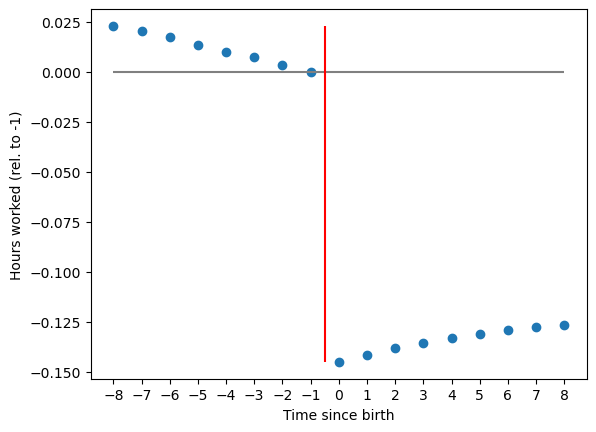

In [32]:
fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel),ymax=np.nanmax(event_hours_rel),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Hours worked (rel. to -1)',xticks=event_grid);